In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deeplense/dataset/val/no/422.npy
/kaggle/input/deeplense/dataset/val/no/331.npy
/kaggle/input/deeplense/dataset/val/no/2434.npy
/kaggle/input/deeplense/dataset/val/no/280.npy
/kaggle/input/deeplense/dataset/val/no/970.npy
/kaggle/input/deeplense/dataset/val/no/2467.npy
/kaggle/input/deeplense/dataset/val/no/2424.npy
/kaggle/input/deeplense/dataset/val/no/745.npy
/kaggle/input/deeplense/dataset/val/no/100.npy
/kaggle/input/deeplense/dataset/val/no/1200.npy
/kaggle/input/deeplense/dataset/val/no/1170.npy
/kaggle/input/deeplense/dataset/val/no/1876.npy
/kaggle/input/deeplense/dataset/val/no/719.npy
/kaggle/input/deeplense/dataset/val/no/1041.npy
/kaggle/input/deeplense/dataset/val/no/193.npy
/kaggle/input/deeplense/dataset/val/no/1191.npy
/kaggle/input/deeplense/dataset/val/no/461.npy
/kaggle/input/deeplense/dataset/val/no/2196.npy
/kaggle/input/deeplense/dataset/val/no/63.npy
/kaggle/input/deeplense/dataset/val/no/1364.npy
/kaggle/input/deeplense/dataset/val/no/1740.npy
/ka

In [4]:
import os
import gc
import glob
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

#Loading image and plotting visualizations/images
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

#PyTorch framework
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import DataLoader, Dataset
from torchvision import utils

#Evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc

#For pre-trained model
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
import timm

np.random.seed(7)
torch.manual_seed(7)

device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform = None):
        root_list = glob.glob(root_dir)
        self.class_map = {}
        self.class_distribution = {}
        self.transform = transform

        for img_path in root_list:
            class_name = img_path.split(os.sep)[-2]
            if class_name not in self.class_distribution:
                self.class_distribution[class_name] = 1
            else:
                self.class_distribution[class_name] +=1

        for index, entity in enumerate(self.class_distribution):
            self.class_map[entity] = index
        print("Dataset Distribution:\n")
        print(self.class_distribution)
        print("\n\nClass indices:\n")
        print(self.class_map)

        self.data = []
        for img_path in tqdm(root_list):
            class_name = img_path.split(os.sep)[-2]
            self.data.append([img_path, class_name])
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = np.load(img_path)
        img = torch.tensor(img, dtype=torch.float)

        class_id = self.class_map[class_name]
        class_id = torch.tensor(class_id)

        return img, class_id

In [6]:
n_batch = 128

In [7]:
train_path = r'../input/deeplense/dataset/train/*/*'
train_dataset = CustomDataset(train_path)

test_path = r'../input/deeplense/dataset/val/*/*'
test_dataset = CustomDataset(test_path)

Dataset Distribution:

{'no': 10000, 'vort': 10000, 'sphere': 10000}


Class indices:

{'no': 0, 'vort': 1, 'sphere': 2}


  0%|          | 0/30000 [00:00<?, ?it/s]

Dataset Distribution:

{'no': 2500, 'vort': 2500, 'sphere': 2500}


Class indices:

{'no': 0, 'vort': 1, 'sphere': 2}


  0%|          | 0/7500 [00:00<?, ?it/s]

In [8]:
train_loader = DataLoader(train_dataset, batch_size = n_batch, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = n_batch, shuffle = False)

In [9]:
single_batch = next(iter(train_loader))
print(f"The dimensions of a single batch is {single_batch[0].shape}")

The dimensions of a single batch is torch.Size([128, 1, 150, 150])


In [10]:
class pre_trained_model(nn.Module):
    
    def __init__(self, pretrained = True):
        super().__init__()
        self.model = timm.create_model('inception_resnet_v2',pretrained = pretrained, in_chans = 1)

        
        for param in self.model.parameters():
            param.requires_grad = True            
        
        self.fc = nn.Sequential(
                                nn.Linear(1536 * 3 * 3, 1024),
                                nn.PReLU(),
                                nn.BatchNorm1d(1024),
                                nn.Dropout(p = 0.5),
        
                                nn.Linear(1024, 128),
                                nn.PReLU(),
                                nn.BatchNorm1d(128),
                                nn.Dropout(p = 0.5),
                                
                                nn.Linear(128, 3)
                                )
        
    def forward(self, x):
        x = self.model.forward_features(x)
        x = x.view(-1, 1536 * 3 * 3)
        x = self.fc(x)
        return x

In [11]:
model = pre_trained_model()
x = torch.randn(128, 1, 150, 150)
model(x).shape

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/inception_resnet_v2-940b1cd6.pth" to /root/.cache/torch/hub/checkpoints/inception_resnet_v2-940b1cd6.pth


torch.Size([128, 3])

In [12]:
def calculate_accuracy(y_pred, y_truth):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_labels = torch.max(y_pred_softmax, dim = 1)
    
    correct_preds = (y_pred_labels == y_truth).float()
    acc = correct_preds.sum() / len(correct_preds)
    acc = torch.round(acc*100)
    
    return acc  

In [13]:
def train_epoch(model, dataloader, criterion, optimizer):
    model.train()
    train_loss = []
    train_accuracy = []

    loop=tqdm(enumerate(dataloader),total = len(dataloader))

    for batch_idx, (img_batch,labels) in loop:

        X = img_batch.to(device)
        y_truth = labels.to(device)
        
        #forward prop
        y_pred = model(X)
        
        #loss and accuracy calculation
        loss = criterion(y_pred, y_truth)
        accuracy = calculate_accuracy(y_pred, y_truth)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #batch loss and accuracy
        # print(f'Partial train loss: {loss.data}')
        train_loss.append(loss.detach().cpu().numpy())
        train_accuracy.append(accuracy.detach().cpu().numpy())

    return model, np.mean(train_loss), np.mean(train_accuracy)

In [14]:
def val_epoch(model, dataloader,criterion):
    model.eval()
    val_loss = []
    val_accuracy = []

    with torch.no_grad():

        loop=tqdm(enumerate(dataloader),total=len(dataloader))
        
        for batch_idx, (img_batch,labels) in loop:
            X = img_batch.to(device)
            y_truth = labels.to(device)

            #forward prop
            y_pred = model(X)

            #loss and accuracy calculation
            loss = criterion(y_pred, y_truth)
            accuracy = calculate_accuracy(y_pred, y_truth)


            #batch loss and accuracy
            # print(f'Partial train loss: {loss.data}')
            val_loss.append(loss.detach().cpu().numpy())
            val_accuracy.append(accuracy.detach().cpu().numpy())
            
    return np.mean(val_loss), np.mean(val_accuracy)

In [15]:
def fit_model(model,criterion,optimizer):
    loss_dict = {'train_loss':[],'val_loss':[]}
    acc_dict = {'train_accuracy':[],'val_accuracy':[]}
    
    for epoch in range(EPOCHS):
        print(f"Epoch {epoch+1}/{EPOCHS}:")
        model, train_loss, train_accuracy = train_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_accuracy = val_epoch(model, test_loader, criterion)

        print(f'Train loss:{train_loss}, Val loss:{val_loss}')
        loss_dict['train_loss'].append(train_loss)
        loss_dict['val_loss'].append(val_loss)
        print(f'Train accuracy: {train_accuracy}, Val accuracy:{val_accuracy}')
        acc_dict['train_accuracy'].append(train_accuracy)
        acc_dict['val_accuracy'].append(val_accuracy)


    return model, loss_dict, acc_dict

In [16]:
model = pre_trained_model().to(device)

criterion = nn.CrossEntropyLoss()
EPOCHS = 10
LR = 3e-4

optimizer = optim.Adam(model.parameters(),lr=LR)

In [17]:
model, loss_dict, acc_dict = fit_model(model,criterion,optimizer)

Epoch 1/10:


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Train loss:1.002152681350708, Val loss:0.8021559119224548
Train accuracy: 50.96595764160156, Val accuracy:66.18643951416016
Epoch 2/10:


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Train loss:0.6268280744552612, Val loss:0.5357437133789062
Train accuracy: 73.92765808105469, Val accuracy:77.3559341430664
Epoch 3/10:


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Train loss:0.4106883406639099, Val loss:0.4026755392551422
Train accuracy: 83.89787292480469, Val accuracy:84.2033920288086
Epoch 4/10:


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Train loss:0.2977387011051178, Val loss:0.3769087493419647
Train accuracy: 88.52765655517578, Val accuracy:85.81356048583984
Epoch 5/10:


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Train loss:0.2279607504606247, Val loss:0.3682645261287689
Train accuracy: 91.48085021972656, Val accuracy:85.28813934326172
Epoch 6/10:


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Train loss:0.16481749713420868, Val loss:0.37281522154808044
Train accuracy: 93.98297882080078, Val accuracy:86.62712097167969
Epoch 7/10:


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Train loss:0.12654346227645874, Val loss:0.4152495563030243
Train accuracy: 95.39148712158203, Val accuracy:87.4237289428711
Epoch 8/10:


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Train loss:0.09697275608778, Val loss:0.39847663044929504
Train accuracy: 96.46382904052734, Val accuracy:87.74576568603516
Epoch 9/10:


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Train loss:0.08480963110923767, Val loss:0.4740733802318573
Train accuracy: 97.02127838134766, Val accuracy:84.62712097167969
Epoch 10/10:


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Train loss:0.05510907620191574, Val loss:0.47967514395713806
Train accuracy: 98.0851058959961, Val accuracy:86.52542114257812


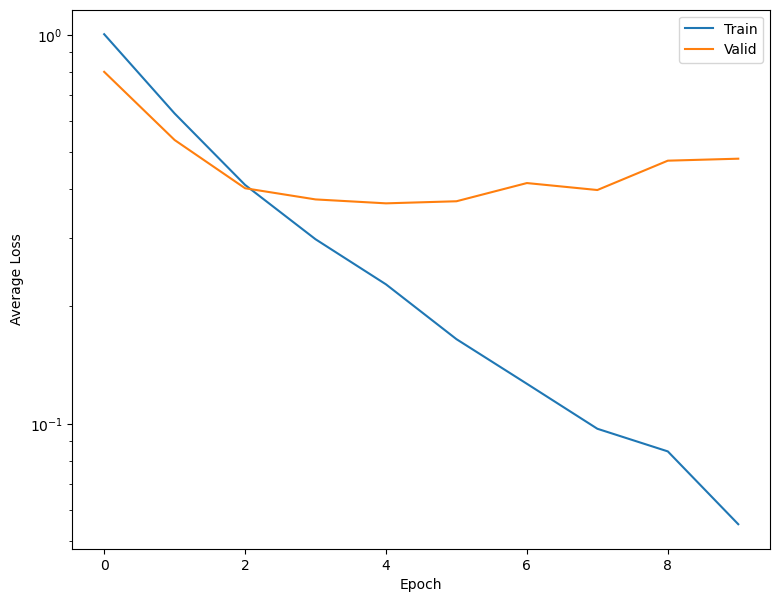

In [18]:
plt.figure(figsize=(9,7))
plt.semilogy(loss_dict['train_loss'], label='Train')
plt.semilogy(loss_dict['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

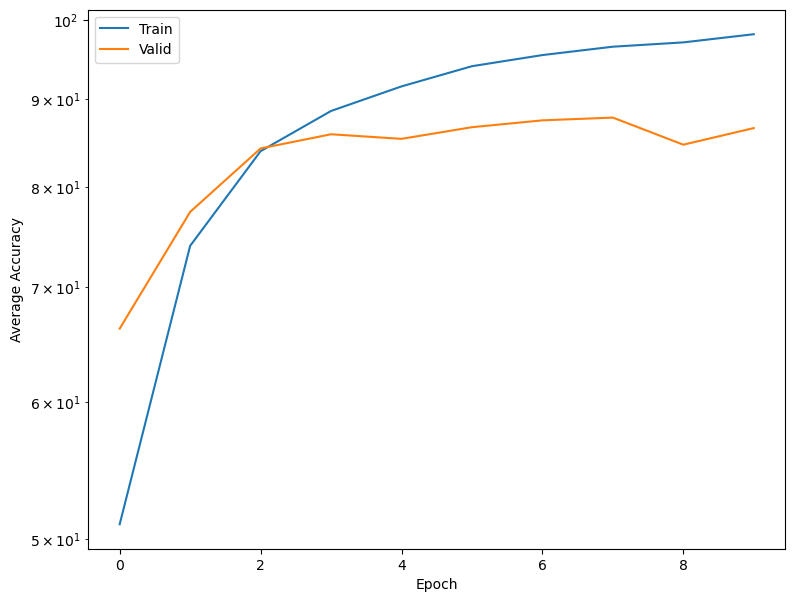

In [19]:
# Plot accuracy
plt.figure(figsize=(9,7))
plt.semilogy(acc_dict['train_accuracy'], label='Train')
plt.semilogy(acc_dict['val_accuracy'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

In [20]:
def test_epoch(model, dataloader,criterion):

    model.eval()
    test_loss = []
    test_accuracy = []
    
    y_pred_list = []
    y_truth_list = []
    y_pred_prob_list= []

    with torch.no_grad():

        loop=tqdm(enumerate(dataloader),total=len(dataloader))
        
        for batch_idx, (img_batch,labels) in loop:
            X = img_batch.to(device)
            y_truth = labels.to(device)
            y_truth_list.append(y_truth.detach().cpu().numpy())

            
            y_pred = model(X)
            y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
            y_pred_prob_list.append(y_pred_softmax.detach().cpu().numpy())
            _, y_pred_labels = torch.max(y_pred_softmax, dim = 1)
            y_pred_list.append(y_pred_labels.detach().cpu().numpy())

           
            loss = criterion(y_pred, y_truth)
            accuracy = calculate_accuracy(y_pred, y_truth)


            
            test_loss.append(loss.detach().cpu().numpy())
            test_accuracy.append(accuracy.detach().cpu().numpy())
            
    return y_pred_prob_list, y_pred_list, y_truth_list, np.mean(test_loss), np.mean(test_accuracy)

In [21]:
y_pred_prob_list, y_pred_list, y_truth_list, test_loss, test_accuracy = test_epoch(model, test_loader, criterion)

print(test_loss, test_accuracy)

  0%|          | 0/59 [00:00<?, ?it/s]

0.47967514 86.52542


In [22]:
def flatten_list(x):
    flattened_list = []
    for i in x:
        for j in i:
            flattened_list.append(j)
            
    return flattened_list

In [23]:
y_pred_list_flattened = flatten_list(y_pred_list)
y_truth_list_flattened = flatten_list(y_truth_list)
y_pred_prob_list_flattened = flatten_list(y_pred_prob_list)

In [24]:
idx2class = {v: k for k, v in train_dataset.class_map.items()}
class_names = [i for i in train_dataset.class_map.keys()]
idx2class

{0: 'no', 1: 'vort', 2: 'sphere'}

In [25]:
print(classification_report(y_truth_list_flattened, y_pred_list_flattened,target_names = class_names))

              precision    recall  f1-score   support

          no       0.90      0.86      0.88      2500
        vort       0.90      0.86      0.88      2500
      sphere       0.80      0.87      0.84      2500

    accuracy                           0.87      7500
   macro avg       0.87      0.87      0.87      7500
weighted avg       0.87      0.87      0.87      7500



In [26]:
print(confusion_matrix(y_pred_list_flattened, y_truth_list_flattened))

[[2155   64  166]
 [  86 2151  150]
 [ 259  285 2184]]


<AxesSubplot:>

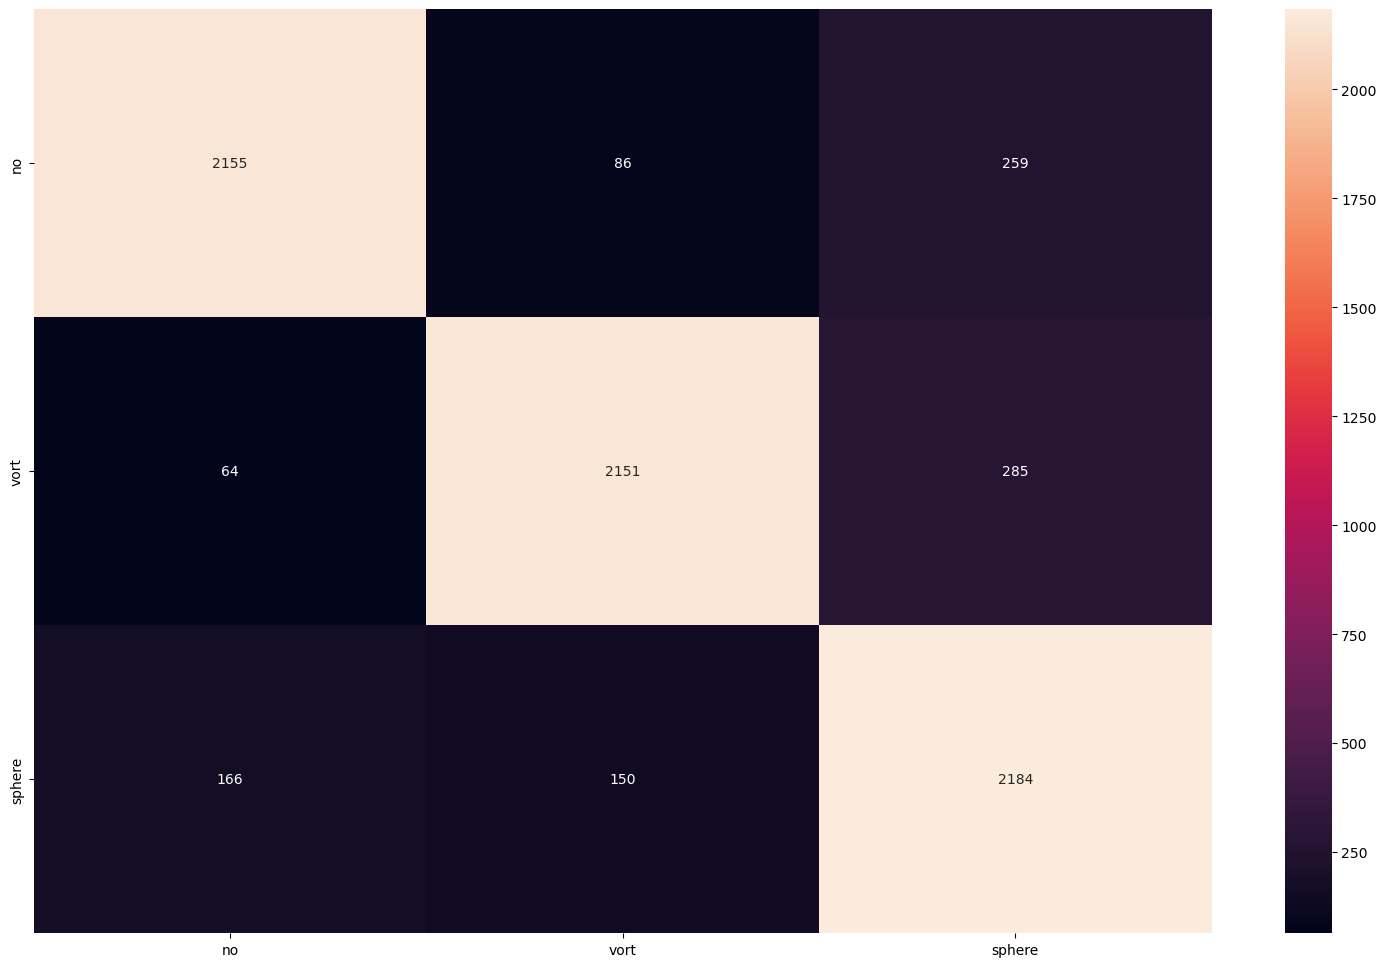

In [27]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_truth_list_flattened, y_pred_list_flattened)).rename(columns=idx2class, index=idx2class)
fig, ax = plt.subplots(figsize=(19,12))         
sns.heatmap(confusion_matrix_df, fmt = ".0f", annot=True, ax=ax)

In [28]:
temp_test_y = []

for i in range(len(y_truth_list_flattened)):
    a = [0, 0, 0]
    a[y_truth_list_flattened[i]] = 1
    temp_test_y.append(a)

temp_test_y = np.array(temp_test_y)
temp_test_y.shape

(7500, 3)

In [29]:
temp_test_y[0:5]

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

In [30]:
y_pred_prob_list_flattened = np.array(y_pred_prob_list_flattened)
y_pred_prob_list_flattened.shape

(7500, 3)

In [31]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(temp_test_y[:, i], y_pred_prob_list_flattened[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

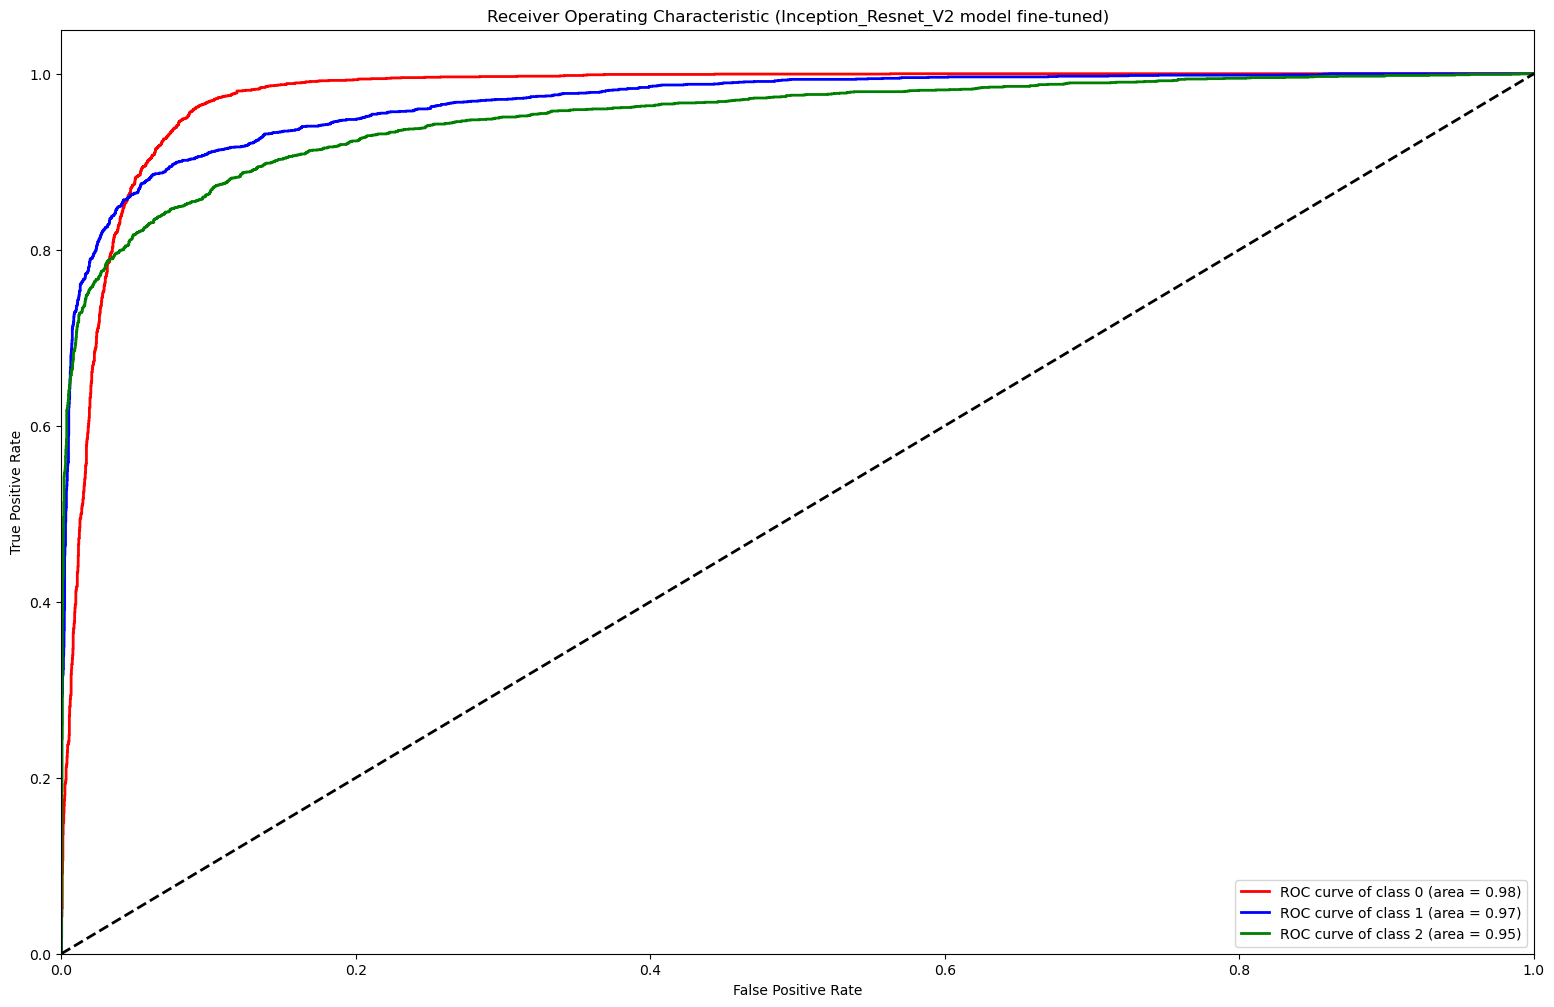

In [32]:
colors = ['red', 'blue', 'green']
plt.figure(figsize = (19, 12))

for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_auc[i]))
             
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Inception_Resnet_V2 model fine-tuned)')
plt.legend(loc="lower right")
plt.show()

In [33]:
auc = roc_auc_score(temp_test_y, y_pred_prob_list_flattened,multi_class="ovo")
print('AUC: %.3f' % auc)

AUC: 0.965
